In [27]:
import argparse
from pathlib import Path
from data_processing import DataProcessor
from models import ModelTrainer
from feature_selection import FeatureSelector
from visualization import Visualizer
from causal_inference import CausalInference
import shap
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib
from evaluation import calculate_metrics, iterative_feature_deletion_scores, iterative_feature_addition_scores, evaluate_global_shap_scores
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")



In [6]:
print("Starting ML Pipeline...")
base_dir = '../../../'
print(f"Base directory set to: {base_dir}")

data_path = base_dir + 'dataset/' + 'data_full.xlsx'
raw_data_path = base_dir + 'dataset/' + 'result_raw.xlsx'
result_dir = base_dir + 'result/'

report_file_path = result_dir + 'report.txt'

print("Loading data...")
data_processor = DataProcessor(data_path=str(data_path))
df = data_processor.load_data_metabolites()
print("Data loaded successfully.")

Starting ML Pipeline...
Base directory set to: ../../../
Loading data...
Data loaded successfully.


In [7]:
print("Preprocessing raw data...")
raw_df = data_processor.preprocess_raw_data(raw_data_path=str(raw_data_path))
print("Raw data preprocessed successfully.")

print("Encoding labels...")
df_encoded, label_encoder = data_processor.encode_labels(df, label_column='Group')
print("Labels encoded successfully.")

X = df_encoded.drop(columns=['Group'])
y = df_encoded['Group']

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)
print("Model trained successfully.")

Preprocessing raw data...
Raw data preprocessed successfully.
Encoding labels...
Labels encoded successfully.
Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Model trained successfully.


In [8]:
print("Evaluating model...")
accuracy, report = model_trainer.evaluate_model()
print(accuracy)
print(report)
print("Model evaluation completed.")

print("Saving trained model...")
model_trainer.save_model(str(result_dir + 'best_random_forest_model.pkl'))
print("Model saved successfully.")



Evaluating model...
0.8378378378378378
              precision    recall  f1-score   support

           0       1.00      0.54      0.70        26
           1       0.80      1.00      0.89        48

    accuracy                           0.84        74
   macro avg       0.90      0.77      0.79        74
weighted avg       0.87      0.84      0.82        74

Model evaluation completed.
Saving trained model...
Model saved successfully.


In [9]:
predicted_probabilities = model.predict_proba(X)

prob_df = pd.DataFrame(predicted_probabilities, columns=[f'Prob_Class_{i}' for i in range(predicted_probabilities.shape[1])])

result_df = pd.concat([X.reset_index(drop=True), prob_df.reset_index(drop=True)], axis=1)

result_df.to_excel('data_full_predicted_probabilities.xlsx', index=False)

print("Predicted probabilities exported successfully to 'predicted_probabilities.xlsx'.")


Predicted probabilities exported successfully to 'predicted_probabilities.xlsx'.


In [10]:
print("Performing feature selection using Gini importance...")
feature_selector = FeatureSelector(model, model_trainer.X_train)
selected_features_gini = feature_selector.gini_importance(threshold=0.001)
sorted_features = selected_features_gini.sort_values(ascending=False)

top_30_features = sorted_features.head(30)

print("Top 30 features selected based on Gini importance:")
print(top_30_features.to_list())


Performing feature selection using Gini importance...
Top 30 features selected based on Gini importance:
['xylose', 'xanthosine', 'valylglutamine', 'valine betaine', 'ursodeoxycholate sulfate (1)', 'uracil', 'tyrosine', 'tryptophylglycine', "trigonelline (N'-methylnicotinate)", 'tricarballylate', 'thymine', 'threonine', 'thiamin (Vitamin B1)', 'theobromine', 'syringic acid', 'succinimide', 'succinate', 'stearate (18:0)', 'stachydrine', 'sphingosine', 'serotonin', 'serine', 'salicylate', 'saccharin', 'ribulose/xylulose', 'riboflavin (Vitamin B2)', 'ribitol', 'quinolinate', 'quinate', 'pyroglutamine*']


## Using the Predicted Probability for the PC to find Causal Edge that is directed to 'Group'

In [11]:
X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

print("Training Random Forest model...")
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 7],
    'min_samples_leaf': [1, 2, 4]
}
model_trainer = ModelTrainer(X, y)
model, best_params = model_trainer.train_random_forest(param_dist)

Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [12]:
print("Evaluating model...")
accuracy, report = model_trainer.evaluate_model()
print(accuracy)
print(report)
print("Model evaluation completed.")

print("Saving trained model...")
model_trainer.save_model(str(result_dir + 'IBS_model.pkl'))
print("Model saved successfully.")



Evaluating model...
0.8108108108108109
              precision    recall  f1-score   support

           0       0.77      0.65      0.71        26
           1       0.83      0.90      0.86        48

    accuracy                           0.81        74
   macro avg       0.80      0.77      0.78        74
weighted avg       0.81      0.81      0.81        74

Model evaluation completed.
Saving trained model...
Model saved successfully.


Applying SHAP for explainability...


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\snorl\\Desktop\\FYP\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Users\\snorl\\Desktop\\FYP\\venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='c:\\Use

[[ 0.11486443  0.00215567 -0.00492032 ...  0.00259128  0.00904321
   0.00863349]
 [ 0.10000743  0.00203317  0.00230973 ... -0.00419223  0.06047792
  -0.04543462]
 [ 0.07868715 -0.00294276  0.00325913 ...  0.00361019  0.00143554
  -0.00804236]
 ...
 [ 0.10458976 -0.00627233 -0.00065106 ...  0.00192314 -0.01925262
   0.01460433]
 [-0.13420773 -0.01879415 -0.00743571 ... -0.02944572  0.10006502
  -0.0198078 ]
 [-0.16033108  0.00603943  0.0112974  ... -0.00786244 -0.05561119
  -0.02222319]]


DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\FRAMDCN.TTF', name='Franklin Gothic Medium Cond', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ITCKRIST.TTF', name='Kristen ITC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\HTOWERTI.TTF', name='High Tower Text', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\CALIFI.TTF', name='Californian FB', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STFANGSO.TTF', name='STFangsong', style='normal', variant='nor

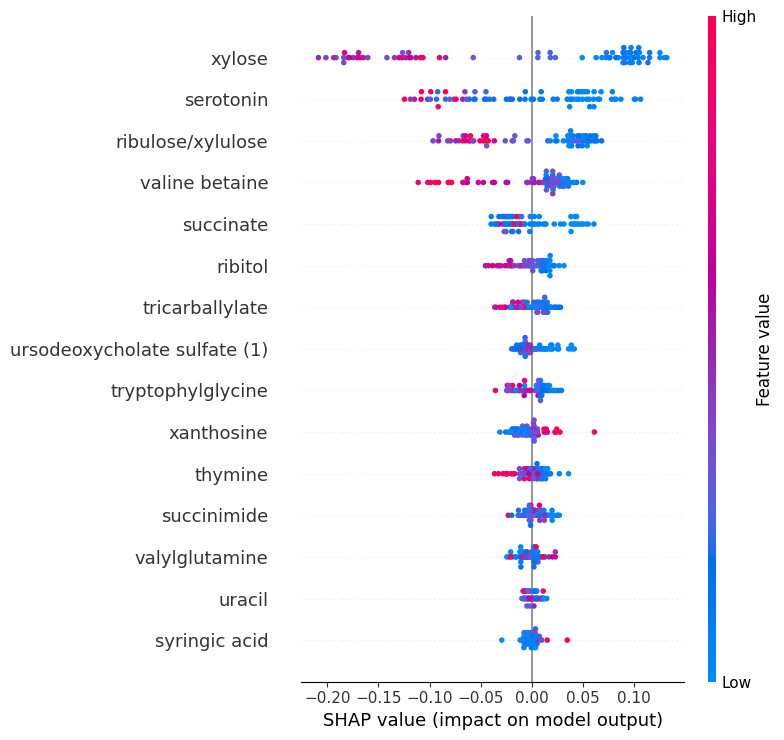

In [13]:
print("Applying SHAP for explainability...")

# Use KMeans background data for SHAP Kernel Explainer
explainer = shap.TreeExplainer(model, model_trainer.X_train)

# Calculate SHAP values
shap_values = explainer.shap_values(model_trainer.X_test)

# Plot SHAP summary
shap_values_class1 = shap_values[:, :, 1]  # Shape: (74, 30)
print(shap_values_class1)
shap.summary_plot(shap_values[:,:,1], model_trainer.X_test)

In [10]:
from causal_inference import CausalInference

In [11]:
i = 0 # Example test instance
# SHAP sum and model prediction comparison

shap_sum = np.sum(shap_values[:][:][i][:,1]) + explainer.expected_value
model_prediction = model.predict_proba(model_trainer.X_test.iloc[i].values.reshape(1, -1))[0][1]

print(f"Expected Value: {explainer.expected_value}")

print(f"Model prediction: {model_prediction}")
print(f"Sum of SHAP values + expected value: {shap_sum}")

if np.isclose(shap_sum[1], model_prediction, atol=1e-6):
    print("SHAP sum matches the model prediction.")
else:
    print("Discrepancy between SHAP sum and model prediction.")

Expected Value: [0.35825431 0.64174569]
Model prediction: 0.8782824507867614
Sum of SHAP values + expected value: [0.59479107 0.87828245]
SHAP sum matches the model prediction.


In [ ]:
print("Applying causal SHAP values...")
ci = CausalInference(data=model_trainer.X_train, model=model, target_variable='Prob_Class_1')
ci.load_causal_strengths(result_dir + 'Mean_Causal_Effect_IBS.json')
print(ci.gamma)
X_train_scaled_df = pd.DataFrame(model_trainer.X_train, columns=model_trainer.X_train.columns)
X_test_scaled_df = pd.DataFrame(model_trainer.X_test, columns=model_trainer.X_test.columns)

In [ ]:
x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
phi_normalized = ci.compute_modified_shap_proba(x_instance)

# Print modified SHAP values
print("Modified Causal SHAP Values:")
for feature, value in phi_normalized.items():
    print(f"{feature}: {value}")

Modified Causal SHAP Values:
xylose: 0.13225397406207984
xanthosine: -0.0029053634832192075
uracil: 0.010855010703359426
ribulose/xylulose: 0.12729433964303247
valylglutamine: -0.0004056528330309809
tryptophylglycine: 0.0010018551608491394
succinate: 0.00584595653445039
valine betaine: -0.002642197284198119
ursodeoxycholate sulfate (1): -0.0001459521197652923
tricarballylate: 0.00019075913178059008
succinimide: 0.0037575690437436165
thymine: 0.005118826204316526
syringic acid: 0.000631230148497586
serotonin: -0.01461428163472704
ribitol: -0.0038996318229844347


In [ ]:
i = 30
x_instance = pd.Series(X_test_scaled_df.iloc[i], index=X_test_scaled_df.columns)
phi_normalized = ci.compute_modified_shap_proba(x_instance)

# Print modified SHAP values
print("Modified Causal SHAP Values:")
for feature, value in phi_normalized.items():
    print(f"{feature}: {value}")

Modified Causal SHAP Values:
xylose: 0.11311892270392937
xanthosine: -0.001397362104218143
uracil: -0.010857293780255952
ribulose/xylulose: 0.1001839486248588
valylglutamine: -0.0005100126588998503
tryptophylglycine: -0.0007034691256101514
succinate: -0.019074634629714073
valine betaine: 0.0105829258159314
ursodeoxycholate sulfate (1): -8.049816247962688e-05
tricarballylate: 0.00025568023672479644
succinimide: 0.0007743904165757363
thymine: 0.009957546559174616
syringic acid: 0.0005421396914991889
serotonin: 0.05979818392746521
ribitol: 0.0012993817383004785


In [ ]:
# Compare standard SHAP and causal SHAP values
standard_shap_series = pd.Series(shap_values[i][:,1], index=X_test_scaled_df.columns)
causal_shap_series = pd.Series(phi_normalized, index=X_test_scaled_df.columns)
y_predicted = model.predict(X_test_scaled_df.iloc[i].values.reshape(1, -1))
print(f"Instance: {i}")
print(f"Instance Predicted Value: {y_predicted}")

# Apply iterative feature deletion and addition to compare SHAP values
print("Comparing SHAP and Causal SHAP using feature deletion and addition...")
avg_output_standard_deletion = iterative_feature_deletion_with_rmse(
    model=model, input_features=x_instance, attribution_scores=standard_shap_series, y_predicted=y_predicted, top_k=10)

avg_output_causal_deletion = iterative_feature_deletion_with_rmse(
    model=model, input_features=x_instance, attribution_scores=causal_shap_series, y_predicted=y_predicted, top_k=10)

avg_output_standard_addition = iterative_feature_addition_with_rmse(
    model=model, input_features=x_instance, attribution_scores=standard_shap_series, y_predicted=y_predicted, top_k=10)

avg_output_causal_addition = iterative_feature_addition_with_rmse(
    model=model, input_features=x_instance, attribution_scores=causal_shap_series, y_predicted=y_predicted, top_k=10)

print(f"Average RMSE (Standard SHAP - Deletion): {avg_output_standard_deletion}")
print(f"Average RMSE (Causal SHAP - Deletion): {avg_output_causal_deletion}")
print(f"Average RMSE (Standard SHAP - Addition): {avg_output_standard_addition}")
print(f"Average RMSE (Causal SHAP - Addition): {avg_output_causal_addition}")


Instance: 30
Instance Predicted Value: [1]
Comparing SHAP and Causal SHAP using feature deletion and addition...
Average RMSE (Standard SHAP - Deletion): 0.18007532467532458
Average RMSE (Causal SHAP - Deletion): 0.22204404761904759
Average RMSE (Standard SHAP - Addition): 0.17516480880230884
Average RMSE (Causal SHAP - Addition): 0.19388733766233773


### IBS Tree SHAP Experiments

In [13]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    model_trainer = ModelTrainer(X, y, random_state=i)
    model, best_params = model_trainer.train_random_forest(param_dist)

    explainer = shap.TreeExplainer(model, model_trainer.X_train)

    shap_values = explainer.shap_values(model_trainer.X_test)

    result = evaluate_global_shap_scores(model, model_trainer.X_test, model_trainer.y_test, shap_values)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.8397435897435898,
                0.7131410256410257,
                0.6145833333333333,
                0.5737179487179487,
                0.5817307692307693,
                0.6033653846153846,
                0.639423076923077,
                0.6386217948717948,
                0.6810897435897435,
                0.6698717948717949,
                0.6518429487179487,
                0.7471955128205128,
                0.6947115384615384,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.5854290017917382,
                0.7117184396839162,
                0.7458745657755351,
                0.7882211683938165,
                0.81629281154797,
                0.8012005518497218,
              

In [14]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6095732870221622,
            "std": 0.032641059609739335
        },
        "cross_entropy": {
            "mean": 0.8036828308299006,
            "std": 0.028200008983786187
        },
        "brier": {
            "mean": 0.30120618437341495,
            "std": 0.013124072758295892
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.855012392346562,
            "std": 0.028169263307504012
        },
        "cross_entropy": {
            "mean": 0.46717330600936935,
            "std": 0.03577447168804904
        },
        "brier": {
            "mean": 0.147404273467363,
            "std": 0.014720255807790374
        }
    }
}


### IBS Kernel SHAP Experiments

In [5]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    model_trainer = ModelTrainer(X, y, random_state=i)
    model, best_params = model_trainer.train_random_forest(param_dist)

    background_data = shap.kmeans(model_trainer.X_train, 100)
    explainer = shap.KernelExplainer(model.predict_proba, background_data)

    shap_values = explainer.shap_values(model_trainer.X_test)

    result = evaluate_global_shap_scores(model, model_trainer.X_test, model_trainer.y_test, shap_values)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.8397435897435898,
                0.7131410256410257,
                0.6145833333333333,
                0.5737179487179487,
                0.5817307692307693,
                0.5825320512820513,
                0.6145833333333334,
                0.6386217948717948,
                0.6810897435897435,
                0.6602564102564104,
                0.6518429487179487,
                0.7471955128205128,
                0.6947115384615384,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.5854290017917382,
                0.7117184396839162,
                0.7458745657755351,
                0.7882211683938165,
                0.81629281154797,
                0.8518784974388885,
                0.8782272567565552,
                0.8603662885864408,
                0.8846268030968748,

  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.7875,
                0.7458333333333332,
                0.6608333333333333,
                0.56,
                0.6216666666666666,
                0.6291666666666667,
                0.5275000000000001,
                0.5741666666666667,
                0.5783333333333334,
                0.6258333333333334,
                0.5991666666666667,
                0.6058333333333333,
                0.5204166666666666,
                0.5454166666666667,
                0.5
            ],
            "cross_entropy": [
                0.5893880935369175,
                0.6939687843745195,
                0.7861497864710774,
                0.8458936405573276,
                0.8828703216757898,
                0.9095310509334874,
                0.9373059843816347,
                0.8598579037819417,
                0.8939732945679326,
                0.8995061653339594,
                0.91455

  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8387096774193548,
                0.7741935483870968,
                0.7599399849962492,
                0.7351837959489873,
                0.6781695423855963,
                0.6834208552138036,
                0.5858964741185296,
                0.5596399099774944,
                0.5558889722430608,
                0.4951237809452363,
                0.4028507126781695,
                0.46174043510877716,
                0.4246061515378845,
                0.41747936984246065,
                0.5
            ],
            "cross_entropy": [
                0.5193068224943925,
                0.5884276777641769,
                0.606017463133041,
                0.6769923018390795,
                0.713251049802941,
                0.777170066168812,
                0.8097615528760742,
                0.8325013104183201,
                0.8454462470235794,
                0.880687022675766,

  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8286445012787723,
                0.7468030690537085,
                0.7178175618073316,
                0.6317135549872123,
                0.5524296675191817,
                0.6086956521739131,
                0.6325660699062234,
                0.6982097186700768,
                0.711849957374254,
                0.6368286445012787,
                0.5592497868712702,
                0.5196078431372548,
                0.48763853367433935,
                0.550298380221654,
                0.5
            ],
            "cross_entropy": [
                0.5247611733780392,
                0.5992980891784528,
                0.6364483622529632,
                0.7030805887135134,
                0.764792833477202,
                0.7780820786677748,
                0.7962646706446573,
                0.8106359100631979,
                0.8076533497670039,
                0.853825796631459,


  0%|          | 0/74 [00:00<?, ?it/s]DEBUG:shap:weight_vector = array([0.32951193, 0.1774295 , 0.12814353, 0.1048447 , 0.09226334,
       0.08542902, 0.08237798])
DEBUG:shap:num_subset_sizes = 7
DEBUG:shap:num_paired_subset_sizes = 7
DEBUG:shap:self.M = 15
DEBUG:shap:subset_size = 1
DEBUG:shap:nsubsets = np.float64(30.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 684.7257865059703
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 22.824192883532344
DEBUG:shap:subset_size = 2
DEBUG:shap:nsubsets = np.float64(210.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 541.9568679014247
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 2.5807469900067845
DEBUG:shap:subset_size = 3
DEBUG:shap:nsubsets = np.float64(910.0)
DEBUG:shap:self.nsamples*weight_vector[subset_size-1] = 477.6872707634842
DEBUG:shap:self.nsamples*weight_vector[subset_size-1]/nsubsets = 0.5249310667730596
INFO:shap:num_full_subsets = 2
DEBUG:shap:samples_left = 1838
INFO:s

{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.77344336084021,
                0.7531882970742686,
                0.7381845461365341,
                0.7464366091522882,
                0.6459114778694673,
                0.6504126031507876,
                0.5746436609152288,
                0.5333833458364591,
                0.46999249812453114,
                0.6204051012753188,
                0.46924231057764443,
                0.47261815453863465,
                0.481245311327832,
                0.5048762190547638,
                0.5
            ],
            "cross_entropy": [
                0.5584202674130104,
                0.6152823978620233,
                0.659037108740996,
                0.6816295750643078,
                0.7385189827480575,
                0.7741145693503552,
                0.8500390166377951,
                0.8641993400757866,
                0.9009943646743731,
                0.8691958201515381

In [ ]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.6155557286380419,
            "std": 0.025009852723275047
        },
        "cross_entropy": {
            "mean": 0.8044518529261528,
            "std": 0.032395437669372876
        },
        "brier": {
            "mean": 0.30158404917624626,
            "std": 0.015052282006838936
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8548635154444065,
            "std": 0.02849115712478812
        },
        "cross_entropy": {
            "mean": 0.4674328561344403,
            "std": 0.036029267580464895
        },
        "brier": {
            "mean": 0.14747157214087334,
            "std": 0.014843916537739232
        }
    }
}


### IBS Causal SHAP Experiments

In [38]:
import pickle

file_paths = ['../../../result/IBS/Causal_SHAP_IBS_42.pkl', '../../../result/IBS/Causal_SHAP_IBS_123.pkl', '../../../result/IBS/Causal_SHAP_IBS_456.pkl', '../../../result/IBS/Causal_SHAP_IBS_789.pkl', '../../../result/IBS/Causal_SHAP_IBS_1010.pkl']

def load_and_format_shap_values(file_path, feature_names):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # Convert list of dicts to numpy array
    n_samples = len(data)
    n_features = len(feature_names)
    shap_array = np.zeros((n_samples, n_features))
    
    for i, instance in enumerate(data):
        for j, feature in enumerate(feature_names):
            shap_array[i, j] = instance.get(feature, 0)
    
    return shap_array

# Usage
feature_names = X.columns.tolist()
causal_shap_values = []

for file_path in file_paths:
    formatted_values = load_and_format_shap_values(file_path, feature_names)
    causal_shap_values.append(formatted_values)

In [39]:
seeds = [42, 123, 456, 789, 1010]

X = X[["xylose", "xanthosine", "uracil", "ribulose/xylulose", "valylglutamine", "tryptophylglycine", "succinate", "valine betaine", "ursodeoxycholate sulfate (1)", "tricarballylate","succinimide", "thymine", "syringic acid", "serotonin", "ribitol" ]]

y = df_encoded['Group']

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=X.index)

all_scores = {
    'deletion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    },
    'insertion': {
        'auroc': [],
        'cross_entropy': [],
        'brier': []
    }
}

idx = 0
for i in seeds:
    print("Training Random Forest model...")
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 7],
        'min_samples_leaf': [1, 2, 4]
    }
    model_trainer = ModelTrainer(X, y, random_state=i)
    model, best_params = model_trainer.train_random_forest(param_dist)

    result = evaluate_global_shap_scores(model, model_trainer.X_test, model_trainer.y_test, pd.Series(np.abs(causal_shap_values[idx]).mean(axis=0), index=feature_names), causal=True)

    for method in ['deletion', 'insertion']:
        for metric in ['auroc', 'cross_entropy', 'brier']:
            all_scores[method][metric].append(result[method]["average_scores"][metric])

    import json

    print(json.dumps(result, indent=4))

    idx += 1


Training Random Forest model...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
{
    "deletion": {
        "stepwise_metrics": {
            "auroc": [
                0.8020833333333333,
                0.7131410256410257,
                0.7131410256410257,
                0.6145833333333333,
                0.6185897435897436,
                0.6233974358974359,
                0.5817307692307693,
                0.594551282051282,
                0.5953525641025641,
                0.6073717948717949,
                0.5945512820512819,
                0.6378205128205129,
                0.6422275641025641,
                0.4911858974358975,
                0.5
            ],
            "cross_entropy": [
                0.5333619228350892,
                0.6176319966059503,
                0.7117184396839162,
                0.7458745657755351,
                0.7544846458433045,
                0.7643038992941047,
                0.821400464724071,
             

In [40]:
final_results = {
    'deletion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['deletion'].items()
    },
    'insertion': {
        metric: {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
        for metric, scores in all_scores['insertion'].items()
    }
}

print("\nFinal Results:")
print(json.dumps(final_results, indent=4))


Final Results:
{
    "deletion": {
        "auroc": {
            "mean": 0.5992495122013993,
            "std": 0.04507300546645652
        },
        "cross_entropy": {
            "mean": 0.8011950252843064,
            "std": 0.045984127610605406
        },
        "brier": {
            "mean": 0.2994053135800677,
            "std": 0.02054626659289343
        }
    },
    "insertion": {
        "auroc": {
            "mean": 0.8594129015847148,
            "std": 0.022721453409459143
        },
        "cross_entropy": {
            "mean": 0.46454035415932565,
            "std": 0.0314754657562984
        },
        "brier": {
            "mean": 0.1464582190251233,
            "std": 0.013471148605793222
        }
    }
}


#### Archive

In [ ]:
# print("Performing feature selection using SHAP importance...")
# selected_features_shap = feature_selector.shap_importance(model_trainer.X_test, threshold=0.005)
# print("Feature selection (SHAP importance) completed.")

# print("Generating SHAP summary plot...")
# visualizer = Visualizer()
# shap_summary_path = result_dir + 'shap_summary.png'
# visualizer.plot_shap_summary(model, model_trainer.X_test, str(shap_summary_path))
# print(f"SHAP summary plot saved at: {shap_summary_path}")

# print("Performing causal inference...with SHAP selected and Group")
# causal_features = selected_features_shap.to_list() + ['Group']
# df_causal = df_encoded[causal_features]
# causal_inference = CausalInference(df_causal)
# causal_graph = causal_inference.run_pc_algorithm()
# print("Causal inference completed.")

# print("Drawing causal graph...")
# causal_graph_path = result_dir + 'causal_graph.png'
# causal_inference.draw_graph(str(causal_graph_path))
# print(f"Causal graph saved at: {causal_graph_path}")

# print("Writing report...")
# with open(report_file_path, 'w') as report_file:
#     report_file.write("First few rows of the dataset:\n")
#     report_file.write(df.head().to_string())
#     report_file.write("\n\n")
#     report_file.write("Best Parameters:\n")
#     report_file.write(str(best_params))
#     report_file.write("\n\n")
#     report_file.write(f"Accuracy: {accuracy * 100:.2f}%\n\n")
#     report_file.write("Classification Report:\n")
#     report_file.write(report)
#     report_file.write("\n\n")
#     report_file.write("Selected Features (Gini Importance):\n")
#     report_file.write(', '.join(selected_features_gini))
#     report_file.write("\n\n")
#     report_file.write("Selected Features (SHAP Importance):\n")
#     report_file.write(', '.join(selected_features_shap))
#     report_file.write("\n\n")
#     report_file.write(f"SHAP summary plot saved as '{shap_summary_path}'.\n\n")
#     report_file.write(f"Causal graph saved as '{causal_graph_path}'.\n")
# print("Report written successfully.")

# print(f"Report generated at '{report_file_path}'.")
# print("Process completed successfully.")
